In [68]:
import pandas as pd
import numpy as np
import pickle
import time 
import os
from datetime import datetime
from operator import itemgetter
import time

# 需要什么读取什么不要一次性全都读取了，影响程序速度

data_folder_path = '../'
raw_data_path = "../raw_data"
storage_path = "../database_storage"
daily_path = "../daily"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")
DCBS_path = os.path.join(storage_path, "DCBS.pkl")

time1 = time.time()

with open('database_ByZCG\\DCBS_DataFrame.pkl', 'rb') as f:  
    DCBS_DataFrame = pickle.load(f)
    

with open('database_ByZCG\\DTBS_DataFrame.pkl', 'rb') as f:  
    DTBS_DataFrame = pickle.load(f)

    
# 只提取A区中存活的转债的时间序列信息
A_DF = DTBS_DataFrame['A']
A_DF = A_DF[A_DF['ia']==1].copy()

# 提取B区信息
B_DF = DTBS_DataFrame['B']

# 提取C区信息
C_DF = DTBS_DataFrame['C']

# 提取D区信息
D_DF = DTBS_DataFrame['D']

In [69]:
# 回测模块，直接全部照抄backtest
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt,log
from numpy import std

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

def get_current_total_money(current_date, current_money, current_position_details, A_DF):
    
    """
    这个函数用于获取当前时刻账户内现金+转债价值之和,返回账户总市值
    current_date：现在的日期，
    current_money：代表账户内的现金数目,
    current_position_details：传入持仓明细字典（Key是转债代码，Value是持有这只转债的数量，请传入合法转债代码与数量）
    A_DF：全量数据库中的A区，存放3点收盘价
    """
    
    if current_position_details == {}:
        current_total_money = current_money
    else:
        # 获取当日转债价格字典
        current_day_A_DF = A_DF.loc[A_DF['date'] == current_date,['bond_code','dp']].copy()
        current_day_price_Dict = current_day_A_DF.set_index('bond_code')['dp'].to_dict()        
        current_total_money = current_money   
        
        for hold_bond_code,hold_num in current_position_details.items():            
            # price = float(A_DF.loc[(A_DF['bond_code'] == hold_bond_code) & (A_DF['date'] == current_date),'dp'])
            price = current_day_price_Dict[hold_bond_code]
            bond_money = price * hold_num
            current_total_money = current_total_money + bond_money    
            
    return current_total_money

def display(profit, trade_dates_list, C_DF, photo_title, tick_spacing = 10):
    
    # x轴
    x = trade_dates_list[1:]
    
    # 图片名
    photo_title = trade_dates_list[0] + ' 至 ' + trade_dates_list[-1] + '  ' + photo_title
    
    # 获取中证转债指数列表
    zi_df = C_DF[C_DF['date'].isin(trade_dates_list)][['date','zi']].copy()
    zi_df.sort_values('date', ascending=True, inplace=True)
    zi = list(zi_df['zi'])    
    zi_cumulative_return = [zi[index]/zi[0] - 1 for index in range(1, len(zi))]
    zi_weekly_return = [zi[index]/zi[index-1] - 1 for index in range(1,len(zi))]
    
    # 获取累计收益率
    weekly_return = profit
    cumulative_return = []
    
    cr = 1
    for i in profit:
        cr = cr * (i + 1)
        cumulative_return.append(cr - 1)
        
    print('单周收益率：', weekly_return, '\n', '累积收益率：',cumulative_return, 
          '\n用累加算法算出的策略累计收益率：',sum(weekly_return), '\n用累加算法算出的中证转债累计收益率：', sum(zi_weekly_return))
    
    # 绘制累计净收益率曲线图
    plt.figure(figsize=(30,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    plt.plot(x, cumulative_return, color='red', label="策略累计净收益率",linewidth=1)
    plt.plot(x, zi_cumulative_return, color='green', label="中证转债累计净收益率",linewidth=1)
    plt.xlabel("时间")
    plt.ylabel("累计收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend()
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    # 显示图像
    plt.show()
    
    # 绘制单周净收益率曲线图
    plt.figure(figsize=(30,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    plt.plot(x, weekly_return, color='red', label="策略单周净收益率",linewidth=1)
    plt.plot(x, zi_weekly_return, color='green', label="中证转债单周净收益率",linewidth=1)
    plt.xlabel("时间")
    plt.ylabel("单周收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend()
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    # 显示图像
    plt.show()
    
    return weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return


def calculate_indicators(trade_dates_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return):
    # 用于获取各类指标
    
    # 周期
    print('周期：', trade_dates_list[0], '至', trade_dates_list[-1])
        
    # 获取策略累计收益率 my_cumulative_return
    my_cumulative_return = cumulative_return[-1]
    print(f'策略累计收益率：{round(my_cumulative_return * 100, 2)}%')
    
    # 获取中证转债累计收益率 zzzz_cumulative_return
    zzzz_cumulative_return = zi_cumulative_return[-1]
    print(f'中证转债累计收益率：{round(zzzz_cumulative_return * 100,2)}%')
    
    # 统计胜率1（收益率大于0的比例）,统计的时候应该去除收益率列表中的0值再进行计算，因为那些周期内没有合适的转债买入因此我们选择空仓
    win_rate_one = len([i for i in weekly_return if i > 0]) / len([i for i in weekly_return if i != 0])
    print(f'胜率1（收益率大于0的比例）：{round(win_rate_one * 100, 2)}%')
    
    # 统计胜率2（收益率高于中证转债指数的比例）,统计的时候应该去除收益率列表中的0值再进行计算，因为那些周期内没有合适的转债买入因此我们选择空仓
    win_rate_two = len([i for i in range(len(weekly_return)) if (weekly_return[i] > zi_weekly_return[i]) & (weekly_return[i] != 0)]) / len([i for i in weekly_return if i != 0])
    print(f'胜率2（收益率高于中证转债指数的比例）：{round(win_rate_two * 100, 2)}%')
    
    # 年化夏普比率，下面这三个的算法不确定，需要确认
    # rf为无风险收益率（10年期国债，暂时取2.684%，这个需要随着时间改动）
    rf = 0.027 / 52    
    avg_rate = np.mean(weekly_return)
    std_rate = np.std(weekly_return)
    sharp_ratio = ((avg_rate - rf) / std_rate) * sqrt(52)
    print(f'夏普比率：{round(sharp_ratio,2)}')
    
    
    # 最大回撤 max_drawdown
    max_drawdown = 0
    cumulative_return_list = list(cumulative_return)
    cumulative_return_list.insert(0,0)
    for i in range(1,len(cumulative_return_list)):
        temp = (max(cumulative_return_list[0:i]) - cumulative_return_list[i])/(1 + max(cumulative_return_list[0:i]))
        if max_drawdown < temp:
            max_drawdown = temp                
    print(f'最大回撤：{round(max_drawdown * 100, 2)}%')
    
    # 年化波动率
    log_return_list = [log(i+1) for i in weekly_return]
    Volatility = std(log_return_list) / sqrt(5)
    annualVolatility = Volatility * sqrt(252) 
    print(f'年化波动率：{round(annualVolatility * 100, 2)}%')
    
        
    # 收益最好的一周
    print('收益率最好的一周：',trade_dates_list[weekly_return.index(max(weekly_return))],'至',trade_dates_list[weekly_return.index(max(weekly_return)) + 1])
    
    # 最高单周收益率
    print(f'最高单周收益率：{round(max(weekly_return)*100, 2)}%')
    
    # 收益最差的一周
    print('收益率最差的一周：',trade_dates_list[weekly_return.index(min(weekly_return))],'至',trade_dates_list[weekly_return.index(min(weekly_return)) + 1])
    
    # 最低单周收益率
    print(f'最低单周收益率：{round(min(weekly_return)*100, 2)}%')

# 这个函数的功能是用于绘制不同策略收益对比图
def display_multiple_strategies(profit_dict, trade_dates_list, zi_weekly_return, zi_cumulative_return, photo_title = '各策略累计收益对比图', tick_spacing = 10):    
    # x轴
    x = trade_dates_list[1:]
           
    # 绘制累计净收益率曲线图
    plt.figure(figsize=(40,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    
    plt.plot(x, zi_cumulative_return, label="中证转债",linewidth=1)
    
    for name,my_dict in profit_dict.items():
        my_weekly_return = my_dict['weekly_return']
        my_cumulative_return = my_dict['cumulative_return']
        plt.plot(x, my_cumulative_return, label = name,linewidth=1)
        
    plt.xlabel("时间")
    plt.ylabel("累计收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    
    # 调整绘图区边距，确保图例和刻度完整显示
    plt.subplots_adjust(right=0.8,bottom=0.25)
    
    plt.savefig('result_photo\\各策略累计收益对比图.png')
    # 显示图像
    plt.show()
    
    # 绘制单周净收益率曲线图
    plt.figure(figsize=(40,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    
    plt.plot(x, zi_weekly_return, label="中证转债",linewidth=1)
    for name,my_dict in profit_dict.items():
        my_weekly_return = my_dict['weekly_return']
        my_cumulative_return = my_dict['cumulative_return']
        plt.plot(x, my_weekly_return, label = name,linewidth=1)
    
    plt.xlabel("时间")
    plt.ylabel("单周收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    
    # 调整绘图区边距，确保图例和刻度完整显示
    plt.subplots_adjust(right=0.8,bottom=0.25)
    
    plt.savefig('result_photo\\各策略单周收益对比图.png')
    # 显示图像
    plt.show()

In [70]:
# DataFrame新增列用于存放前一天收盘价、涨跌幅
A_DF.sort_values(by = ['bond_code','date'], inplace=True, ascending=[True,True])
A_DF['lastday_dp'] = A_DF.groupby('bond_code')['dp'].shift(1)
A_DF['change'] = A_DF['dp'] / A_DF['lastday_dp'] - 1
A_DF = pd.merge(A_DF, B_DF[['bond_code', 'sn', 'cn', 'sc']].drop_duplicates(), on='bond_code', how='left')

# 设定选择区间为n天，得到网格的最高点与最低点
A_DF.sort_values(['bond_code', 'date'], ascending=[True,True], inplace=True)
grouped = A_DF.groupby('bond_code')
n = 126

# 两种不同的计算方式，一种是计算前20天收盘价的最高价、最低价（不含当天），一种是计算前20天收盘价的最高价、最低价（含当天）
# A_DF['highest_price_n_days'] = grouped['dp'].rolling(window=n+1, min_periods=n+1).apply(lambda x: x[:-1].max(), raw=True).reset_index(level=0, drop=True)
# A_DF['lowest_price_n_days'] = grouped['dp'].rolling(window=n+1, min_periods=n+1).apply(lambda x: x[:-1].min(), raw=True).reset_index(level=0, drop=True)

A_DF['highest_price_n_days'] = grouped['dp'].rolling(window=n, min_periods=n).max().reset_index(level=0, drop=True)
A_DF['lowest_price_n_days'] = grouped['dp'].rolling(window=n, min_periods=n).min().reset_index(level=0, drop=True)

# 平均换手率 衡量转债活跃程度
A_DF['avg_trt'] = grouped['trt'].rolling(window=n, min_periods=n).mean().reset_index(level=0, drop=True)

print(A_DF[(A_DF['date']=='2022-01-04') & (A_DF['lowest_price_n_days']>=0)])

        bond_code        date       cpr       dp         bl        trt  \
5812    110038.SH  2022-01-04   13.2906  150.570   6.303800  86.607443   
9056    110043.SH  2022-01-04   20.1582  122.300  29.213500   1.209200   
10303   110044.SH  2022-01-04  124.8837  206.880   0.708500  21.558200   
11545   110045.SH  2022-01-04   29.0305  118.950  29.496400   0.358800   
13003   110047.SH  2022-01-04   20.6081  122.070  22.461600   1.418900   
...           ...         ...       ...      ...        ...        ...   
394628  128141.SZ  2022-01-04   17.2994  130.300  12.702600   0.620400   
395269  128142.SZ  2022-01-04   41.0310  123.698   7.179800   1.282700   
395902  128143.SZ  2022-01-04   14.9148  129.990   2.443800   4.423800   
396502  128144.SZ  2022-01-04   20.7032  142.010   9.794600   0.678600   
397086  128145.SZ  2022-01-04   14.7608  143.661   3.796918   5.130134   

            ytm        yl        dl  ia  ...  hs  redeem_count  lastday_dp  \
5812   -33.5885  0.860274  163.86


 128117.SZ 道恩转债
8810 155.0 113.43
单周收益率： [-0.008117999999999959, -0.0005429678127035764, 0.019635576546509492, 0.009297898641666302, 0.012985123888137995, -0.011907553281276906, -0.008659108174845831, -0.0036510670480531804, -0.006019289105371306, 0.0014219886039821272, 0.007994778464848862, -0.005368739366020114, 0.00451470964473577, -0.0022976888525774175, -0.012736179401537595, 0.0018449456818205867, -0.006881992348531041, 0.005754753524907619, -0.005245007008594538, 0.003850641152167933, 0.001973642959692601, 0.006910028904507426, -0.0075015405610971975, -0.0015656919900199906, 0.004362155734073392, -0.0010858024939432998, 0.003990892842960392, 0.004575629720830809, -0.0035085246246319146, -0.002273571257185525, -0.0006962853830181359, 0.0014014589152917534, 0.005566363243856953] 
 累积收益率： [-0.008117999999999959, -0.008656560000000035, 0.010809040000000047, 0.020207440000000076, 0.033454960000000256, 0.021149040000000285, 0.012306800000000395, 0.008610800000000252, 0.00253968000000

<Figure size 36000x18000 with 0 Axes>

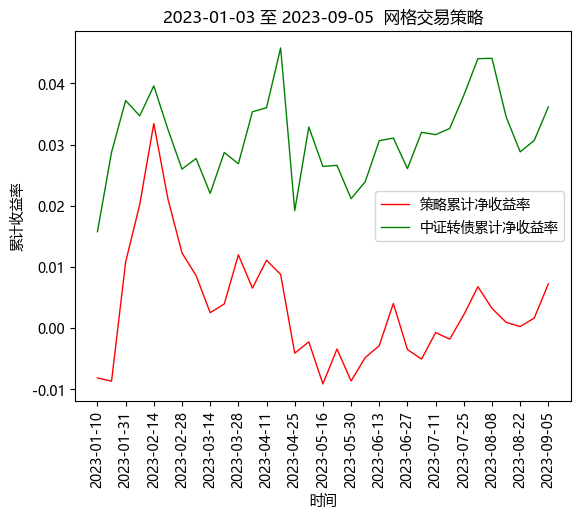

<Figure size 36000x18000 with 0 Axes>

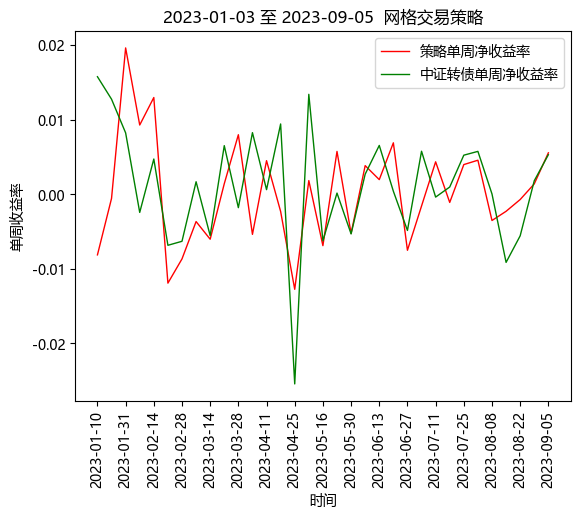

周期： 2023-01-03 至 2023-09-05
策略累计收益率：0.72%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：48.48%
胜率2（收益率高于中证转债指数的比例）：42.42%
夏普比率：-0.29
最大回撤：4.12%
年化波动率：4.93%
收益率最好的一周： 2023-01-17 至 2023-01-31
最高单周收益率：1.96%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-1.27%


周期： 2023-01-03 至 2023-09-05
策略累计收益率：0.28%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：48.48%
胜率2（收益率高于中证转债指数的比例）：39.39%
夏普比率：-0.37
最大回撤：5.09%
年化波动率：5.63%
收益率最好的一周： 2023-01-17 至 2023-01-31
最高单周收益率：2.09%
收益率最差的一周： 2023-02-14 至 2023-02-21
最低单周收益率：-1.57%


<Figure size 48000x18000 with 0 Axes>

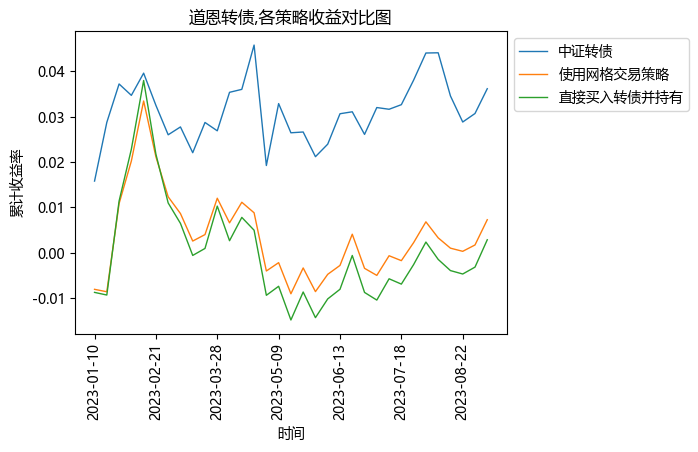

<Figure size 48000x18000 with 0 Axes>

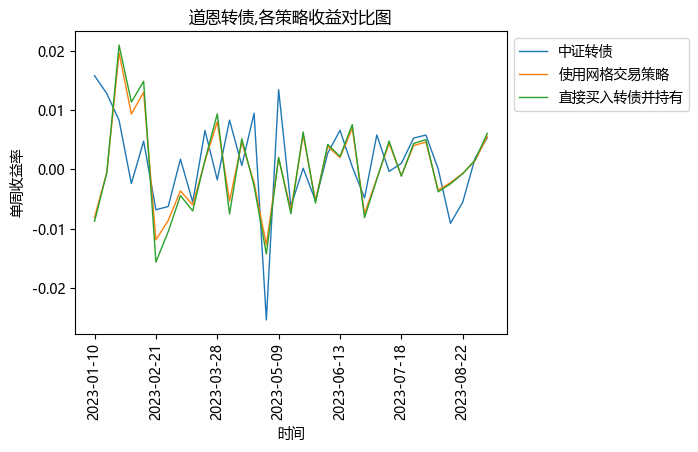


 123088.SZ 威唐转债
8680 146.99 115.096
单周收益率： [0.013713439999999855, 0.0017662979786476907, 0.01887175309488698, 0.022779339040347457, 0.015030418128500145, -0.007033969616953573, -0.014406617620406958, -0.011634463025258834, -0.008056400472265746, 0.00536477641528621, -0.003684824266050657, 0.0021327736114762352, -0.006618403239365356, 0.0019221619478999585, -0.033602514238799674, -0.004929015981314455, -0.009313897095799883, 0.010594893162223284, 0.03043922736788285, -0.009601665873081866, 0.022162718172660245, -0.002147531009475623, -0.003396366176011023, 0.03660111100795138, -0.0021611347000294323, 0.02537009576332383, -0.004389008302842501, -0.009934650576619797, -0.014673556608656435, -0.007775410309145747, -0.001813643762794026, 0.0029169650270042258, 0.009829387716616234] 
 累积收益率： [0.013713439999999855, 0.015503959999999761, 0.03466829999999965, 0.05823735999999968, 0.07414310999999985, 0.06658761999999974, 0.051221699999999926, 0.03899130000000017, 0.030620770000000075, 0.036149

<Figure size 36000x18000 with 0 Axes>

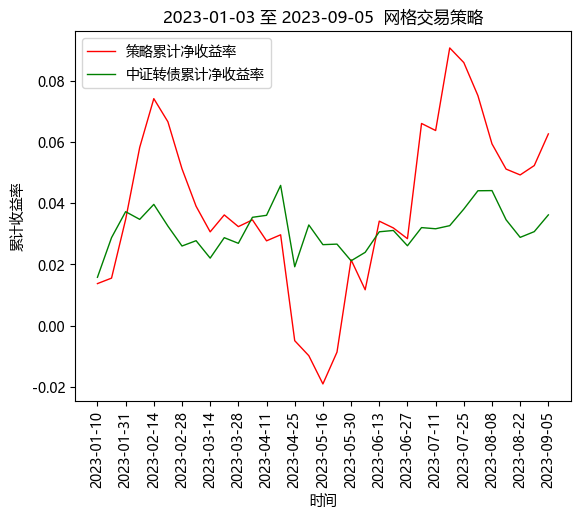

<Figure size 36000x18000 with 0 Axes>

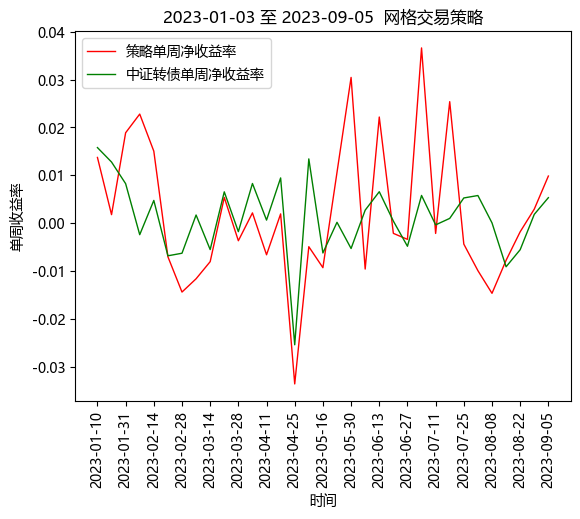

周期： 2023-01-03 至 2023-09-05
策略累计收益率：6.26%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：45.45%
胜率2（收益率高于中证转债指数的比例）：39.39%
夏普比率：0.7
最大回撤：8.68%
年化波动率：10.36%
收益率最好的一周： 2023-06-27 至 2023-07-04
最高单周收益率：3.66%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-3.36%


周期： 2023-01-03 至 2023-09-05
策略累计收益率：3.85%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：45.45%
胜率2（收益率高于中证转债指数的比例）：39.39%
夏普比率：0.3
最大回撤：13.13%
年化波动率：14.27%
收益率最好的一周： 2023-06-27 至 2023-07-04
最高单周收益率：4.93%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-3.96%


<Figure size 48000x18000 with 0 Axes>

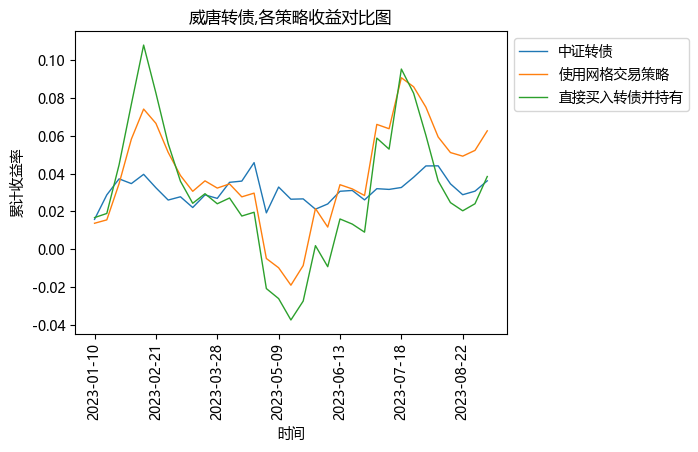

<Figure size 48000x18000 with 0 Axes>

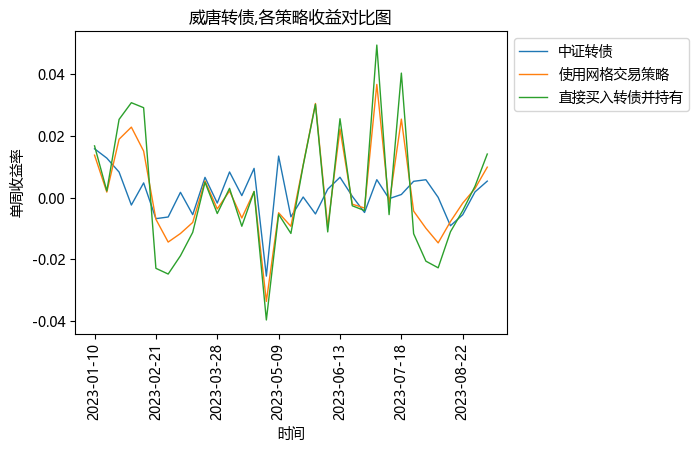


 123038.SZ 联得转债
8010 155.0 124.7
单周收益率： [0.016375200000000145, -0.004691180973325548, 0.025503970315750912, 0.008005342550157613, 0.009598053766237902, -0.0114315071918627, -0.011948489958607866, 0.015965716378125272, 0.005452079731702808, 0.01122400002430246, -0.00876072371914316, 0.009837511346020733, 0.0017931769242889306, -0.001439463159629173, -0.012390328343701129, 0.03557471342929497, 0.03808973454520381, -0.013356532599773208, 0.013977682391141721, 0.008049841227473653, 0.0008917207267977734, 0.007144906743185242, -0.0031805506237062575, 0.01111341933882759, -0.0002826759623391073, 0.016220533043129315, 0.0007614347548137168, -0.0007730616496322007, -0.0003148930856535781, -0.007531981219943362, 0.008228012178196797, -0.0004952557215603948, 0.006217520919649777] 
 累积收益率： [0.016375200000000145, 0.011607200000000262, 0.037407200000000085, 0.045711999999999975, 0.055748800000000154, 0.04367999999999972, 0.03120959999999995, 0.04767359999999998, 0.053385600000000144, 0.06520879999

<Figure size 36000x18000 with 0 Axes>

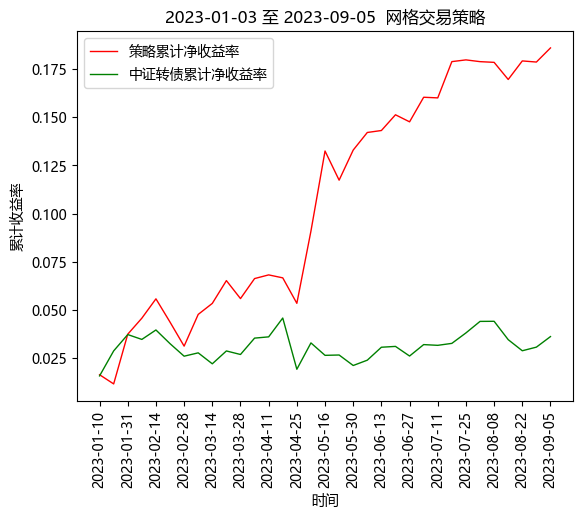

<Figure size 36000x18000 with 0 Axes>

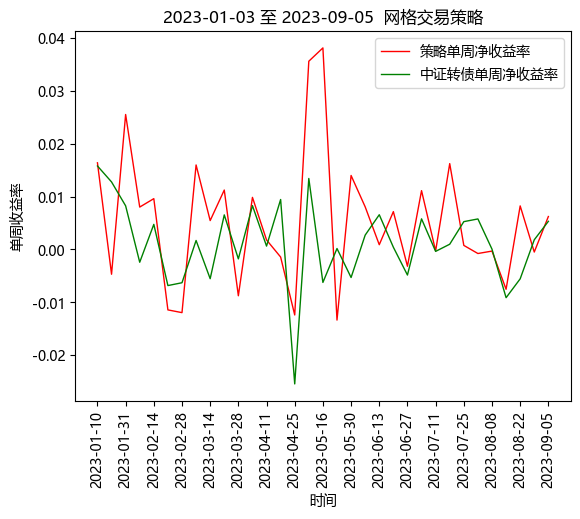

周期： 2023-01-03 至 2023-09-05
策略累计收益率：18.59%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：60.61%
胜率2（收益率高于中证转债指数的比例）：66.67%
夏普比率：2.78
最大回撤：2.32%
年化波动率：8.63%
收益率最好的一周： 2023-05-09 至 2023-05-16
最高单周收益率：3.81%
收益率最差的一周： 2023-05-16 至 2023-05-23
最低单周收益率：-1.34%


周期： 2023-01-03 至 2023-09-05
策略累计收益率：20.45%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：57.58%
胜率2（收益率高于中证转债指数的比例）：51.52%
夏普比率：1.43
最大回撤：10.15%
年化波动率：19.69%
收益率最好的一周： 2023-07-11 至 2023-07-18
最高单周收益率：7.53%
收益率最差的一周： 2023-07-18 至 2023-07-25
最低单周收益率：-5.3%


<Figure size 48000x18000 with 0 Axes>

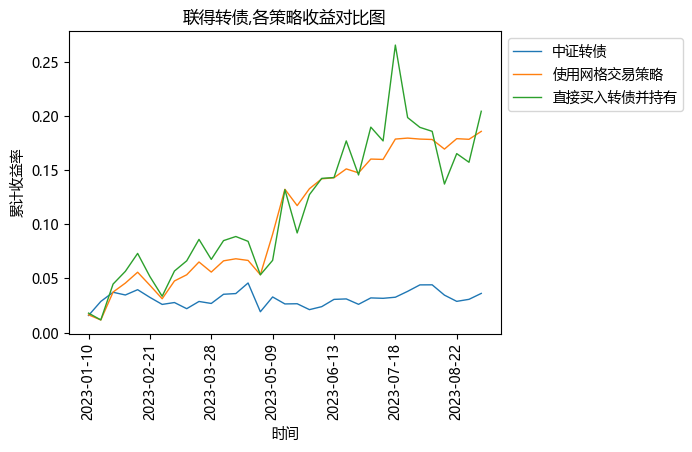

<Figure size 48000x18000 with 0 Axes>

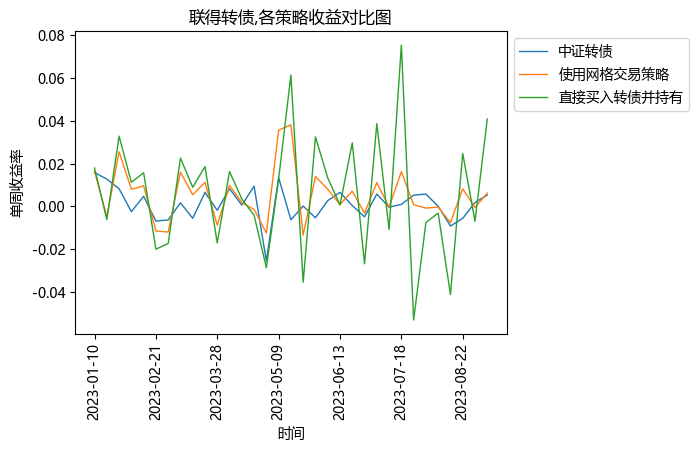


 127028.SZ 英特转债
8640 154.05 115.692
单周收益率： [0.008697600000000083, 0.010437141914484416, 0.02402435920168089, -0.009116578316603507, 0.006045523178434653, 0.019300332027826217, -0.004171565357489526, 0.0002302325975118702, -0.008357843619168137, 0.010251697000639437, 0.0017145139759680017, 0.0028485572259711045, 0.002632346890160342, 0.00356031513898758, -0.027803229938834884, 0.033750182954251695, 0.003212379755982653, -0.004702374946450982, -0.012719450602504567, -0.0031510153370718497, 0.0025595178826853804, 0.0005045427113608003, 0.0038355276592416665, 0.005645009292577496, 0.0038889418144789634, 0.003277508729086387, 0.01007572946780555, -0.003512526296739593, -0.0023121590363520683, 0.0408992766111953, -0.027395562598331535, 0.008104847083092226, 0.005398913664238059] 
 累积收益率： [0.008697600000000083, 0.019225519999999996, 0.04371175999999988, 0.03419667999999976, 0.04044893999999988, 0.06052994999999961, 0.05610587999999961, 0.05634902999999958, 0.04752022999999972, 0.058259089999

<Figure size 36000x18000 with 0 Axes>

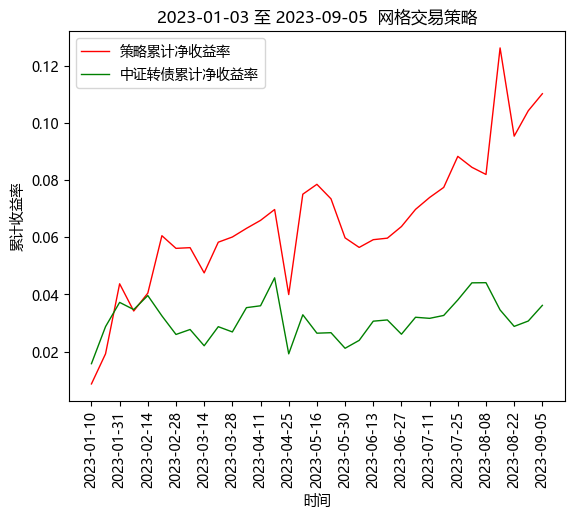

<Figure size 36000x18000 with 0 Axes>

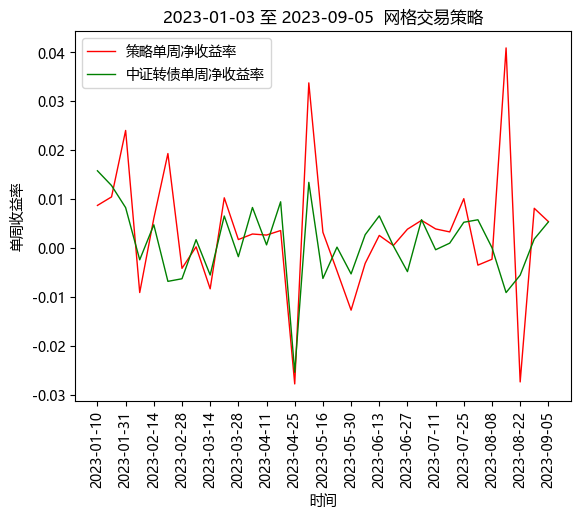

周期： 2023-01-03 至 2023-09-05
策略累计收益率：11.02%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：69.7%
胜率2（收益率高于中证转债指数的比例）：51.52%
夏普比率：1.47
最大回撤：2.78%
年化波动率：9.49%
收益率最好的一周： 2023-08-08 至 2023-08-15
最高单周收益率：4.09%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-2.78%


周期： 2023-01-03 至 2023-09-05
策略累计收益率：10.91%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：66.67%
胜率2（收益率高于中证转债指数的比例）：54.55%
夏普比率：0.7
最大回撤：10.57%
年化波动率：23.02%
收益率最好的一周： 2023-08-08 至 2023-08-15
最高单周收益率：11.26%
收益率最差的一周： 2023-08-15 至 2023-08-22
最低单周收益率：-10.57%


<Figure size 48000x18000 with 0 Axes>

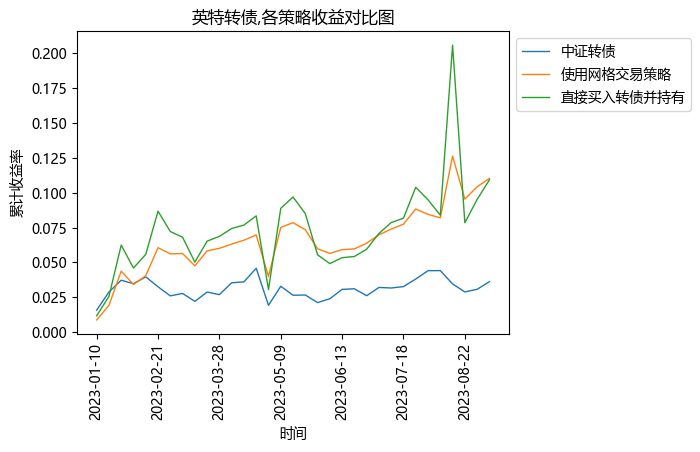

<Figure size 48000x18000 with 0 Axes>

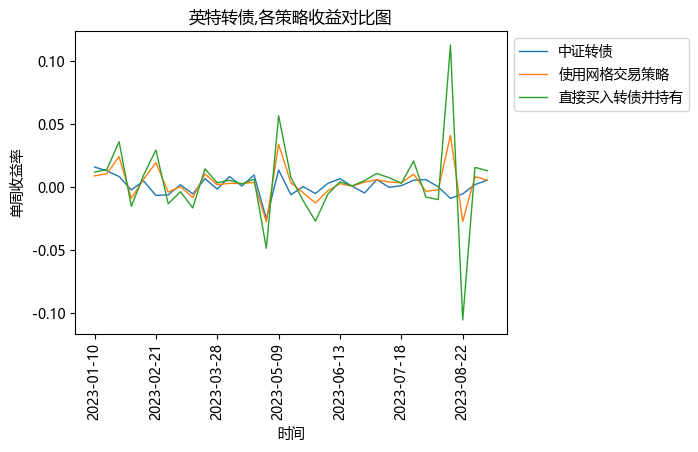


 113600.SH 新星转债
8730 147.26 114.477
单周收益率： [0.014353870000000102, 0.0017329751006915917, 0.020965174971114386, -0.002162221186227997, 0.007584414316792021, 0.019699752851982444, -0.016188421708238865, -0.0012788137840737956, -0.0075074754232337115, 0.00415905222928048, -0.004114547738544583, 0.00036340237644250095, 0.0010225387999194258, -0.0025537357059545185, -0.021097906560000323, -0.00359459345581592, -0.004412554487447484, 0.0050797615049313904, 0.004929870728350716, 0.002714707760842483, 0.004794748169353769, 0.019773209640985945, -0.011772470336976149, 0.02691819385658989, 0.017139509208451642, -0.002305260620976024, 0.004480106828415709, -0.0018741241822991528, 0.0038911363854685632, -0.022306684773512053, -0.005261029266514061, 0.0007603747396565108, 0.01671623679515033] 
 累积收益率： [0.014353870000000102, 0.016111720000000274, 0.03741468000000037, 0.035171560000000435, 0.04302273000000034, 0.06357002000000045, 0.04635250000000046, 0.04501441000000028, 0.03716899000000029, 0.0414

<Figure size 36000x18000 with 0 Axes>

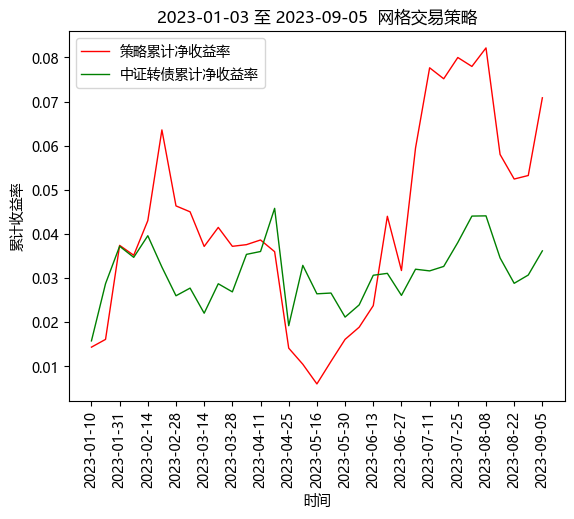

<Figure size 36000x18000 with 0 Axes>

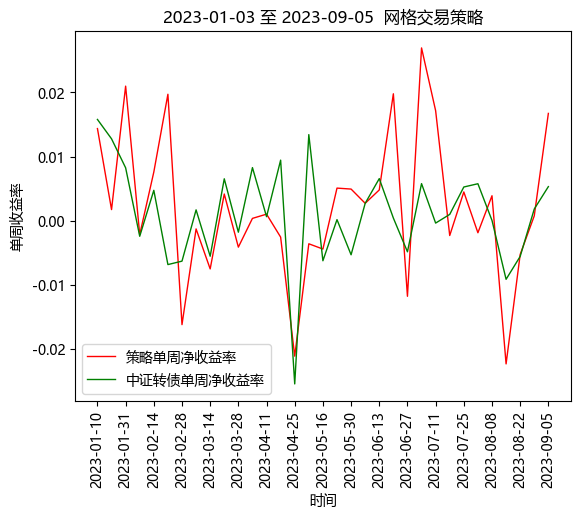

周期： 2023-01-03 至 2023-09-05
策略累计收益率：7.08%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：57.58%
胜率2（收益率高于中证转债指数的比例）：48.48%
夏普比率：1.03
最大回撤：5.41%
年化波动率：8.05%
收益率最好的一周： 2023-06-27 至 2023-07-04
最高单周收益率：2.69%
收益率最差的一周： 2023-08-08 至 2023-08-15
最低单周收益率：-2.23%


周期： 2023-01-03 至 2023-09-05
策略累计收益率：7.38%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：54.55%
胜率2（收益率高于中证转债指数的比例）：39.39%
夏普比率：0.83
最大回撤：7.06%
年化波动率：10.81%
收益率最好的一周： 2023-06-27 至 2023-07-04
最高单周收益率：3.55%
收益率最差的一周： 2023-08-08 至 2023-08-15
最低单周收益率：-3.49%


<Figure size 48000x18000 with 0 Axes>

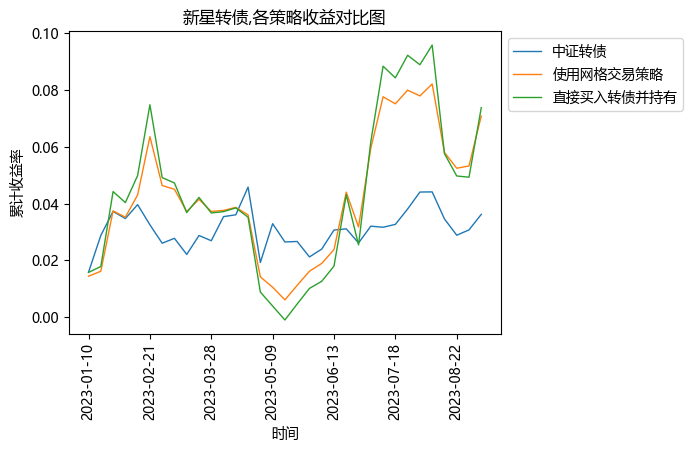

<Figure size 48000x18000 with 0 Axes>

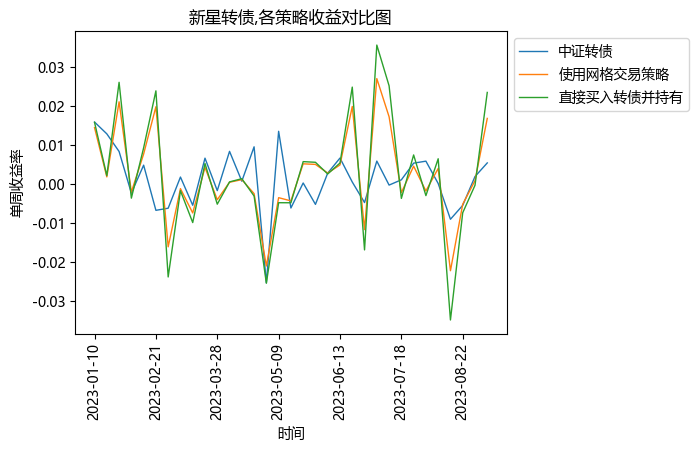


 123145.SZ 药石转债
8450 149.77 118.3
单周收益率： [0.019144569999999916, 0.026516915063384827, 0.011386858534175426, 0.0030398975232270864, 0.0024828460555732512, -0.013734019885195514, -0.004334030666722222, -0.0013861475314239646, 0.0009360936131568298, -0.0026717564086525813, 0.02101027826217261, -0.012706201535137462, 0.005327863285871537, -0.00016713785215660693, -0.0663152126158214, -0.004001553936101798, 0.012002503590831326, -0.0003749672621056188, -0.005468829645274065, -0.006233037831041455, -0.0025716537248945404, 0.006553202816888648, -0.015508875013010237, 0.0012895309789400233, -0.0015489250068098093, -0.00795709196804184, 0.004410185535535405, 0.016181313185013257, -0.008202830386734417, 0.005580317883442154, -0.01838276373405967, -0.00013188040903466813, 0.0012750121031193107] 
 累积收益率： [0.019144569999999916, 0.04616913999999972, 0.05808171999999967, 0.061298179999999425, 0.06393321999999957, 0.04932113999999954, 0.0447733499999996, 0.04332513999999965, 0.04430178999999956, 0.04

<Figure size 36000x18000 with 0 Axes>

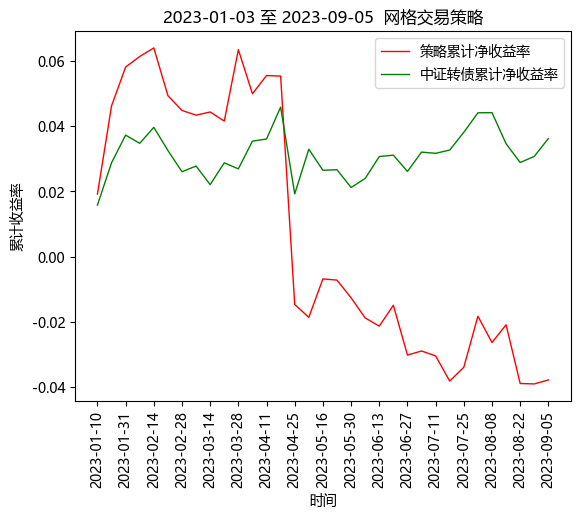

<Figure size 36000x18000 with 0 Axes>

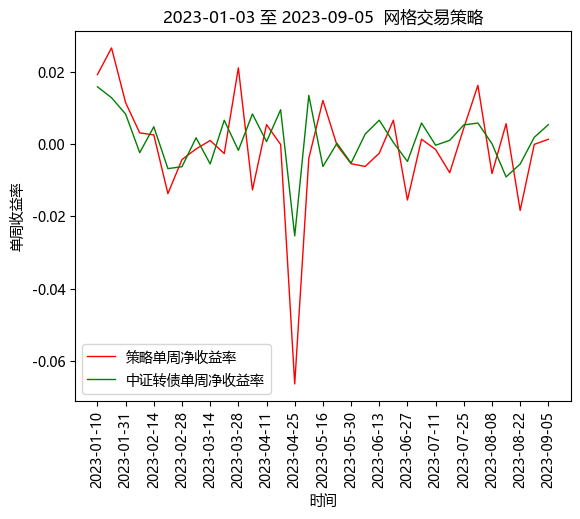

周期： 2023-01-03 至 2023-09-05
策略累计收益率：-3.78%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：45.45%
胜率2（收益率高于中证转债指数的比例）：36.36%
夏普比率：-0.74
最大回撤：9.68%
年化波动率：11.06%
收益率最好的一周： 2023-01-10 至 2023-01-17
最高单周收益率：2.65%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-6.63%


周期： 2023-01-03 至 2023-09-05
策略累计收益率：-7.11%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：45.45%
胜率2（收益率高于中证转债指数的比例）：33.33%
夏普比率：-0.88
最大回撤：14.38%
年化波动率：15.06%
收益率最好的一周： 2023-01-10 至 2023-01-17
最高单周收益率：4.06%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-8.96%


<Figure size 48000x18000 with 0 Axes>

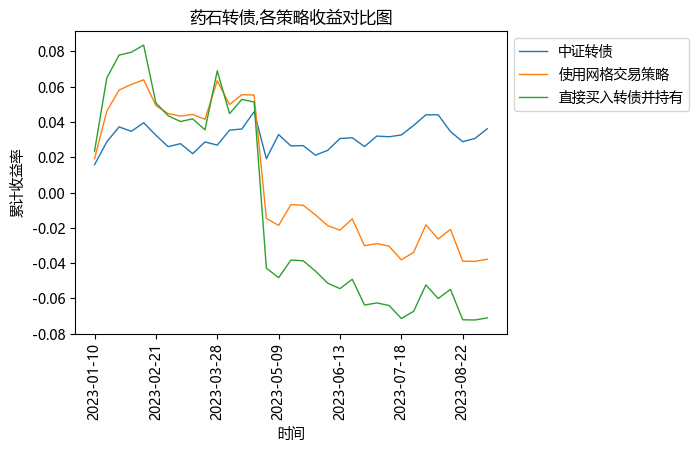

<Figure size 48000x18000 with 0 Axes>

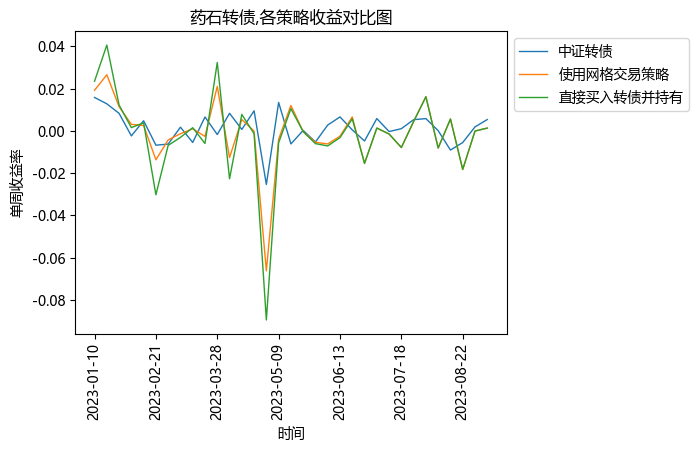


 128042.SZ 凯中转债
8710 149.391 114.8
单周收益率： [0.03881939999999995, 0.007949447228266848, 0.009691432182895365, 0.003293281567127604, 0.00600310061160525, -0.011190175785213974, -0.010654707208463288, -0.0002466923047079739, -0.0154054010391651, 0.013998823110805914, 0.01590386656840903, -0.004916657286359483, -0.005301898967757346, -0.005946295078876673, -0.03969198407697272, -2.6965847529258902e-05, 0.00883894727691703, 0.016511569272294135, -0.0011400639016113656, -0.0022555549013338894, 0.02582218333587183, 0.020156497871260726, -0.006579844775195243, 0.02259988235497734, -0.0036028064785766922, 0.0037411825264779264, -0.009642307709542774, -0.007202110946829543, -0.011729913631059685, -0.013637109358299204, -0.004734949380031495, 0.01429256837703674, 0.013145469968506518] 
 累积收益率： [0.03881939999999995, 0.047077439999999804, 0.057225119999999574, 0.06070685999999981, 0.0670743899999997, 0.05513363999999976, 0.04389149999999975, 0.04363397999999963, 0.027556379999999603, 0.041940959999

<Figure size 36000x18000 with 0 Axes>

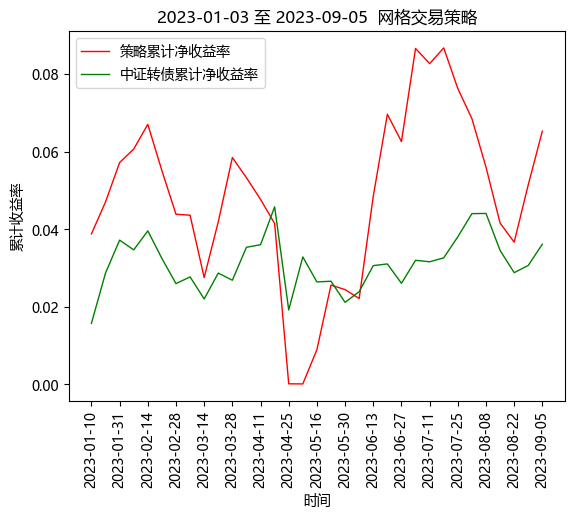

<Figure size 36000x18000 with 0 Axes>

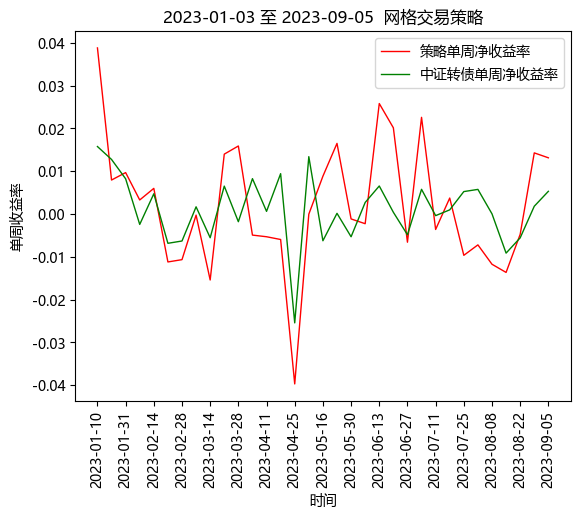

周期： 2023-01-03 至 2023-09-05
策略累计收益率：6.53%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：45.45%
胜率2（收益率高于中证转债指数的比例）：48.48%
夏普比率：0.74
最大回撤：6.27%
年化波动率：10.36%
收益率最好的一周： 2023-01-03 至 2023-01-10
最高单周收益率：3.88%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-3.97%


周期： 2023-01-03 至 2023-09-05
策略累计收益率：4.73%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：45.45%
胜率2（收益率高于中证转债指数的比例）：45.45%
夏普比率：0.4
最大回撤：9.34%
年化波动率：13.7%
收益率最好的一周： 2023-01-03 至 2023-01-10
最高单周收益率：4.64%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-5.0%


<Figure size 48000x18000 with 0 Axes>

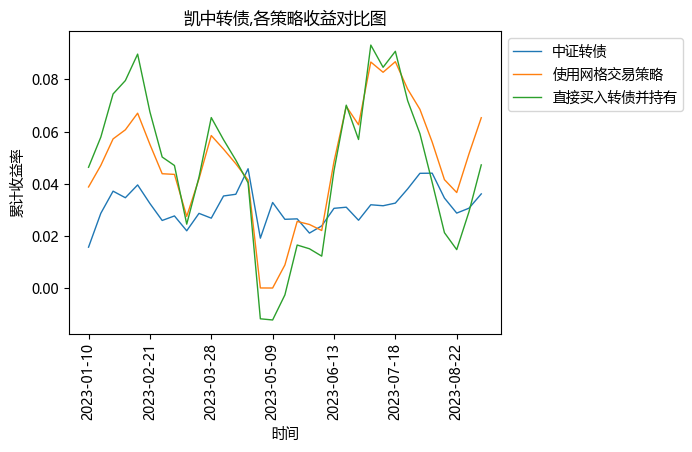

<Figure size 48000x18000 with 0 Axes>

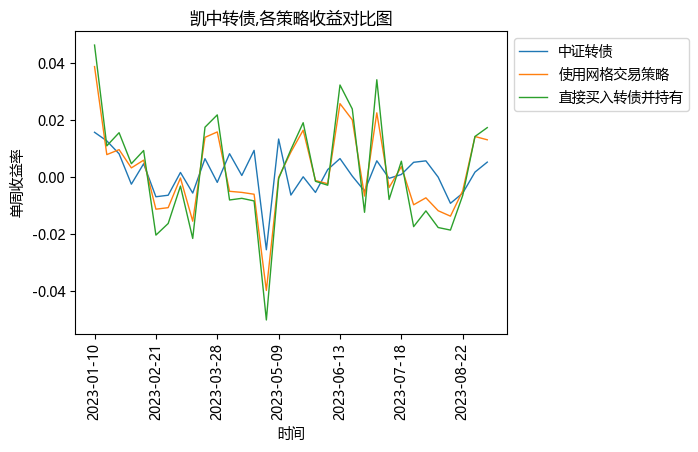


 113636.SH 甬金转债
8740 147.5 114.375
单周收益率： [0.0002830199999999117, 0.007326326503073188, 0.04107037611780906, 0.002165998216959064, 0.015261220342106974, -0.00566427679272552, 0.00858219532228044, -0.021606747639282275, -0.0027246434049406076, 0.011502645371838316, -0.019976719160412992, 0.0009288403653624488, -0.0028793936274807974, 0.013977824838508734, -0.019049003729050273, -0.013783391844146786, 0.001209709928891467, 0.01102133401349037, -0.021976030157389137, 0.008749333046247143, 0.008501431847397933, -0.010541895735084572, -0.0008793120587493597, -0.005220388556282818, 0.0018868475007249863, 0.006009348943253556, 0.021563879074990355, 0.023411373631719412, 0.0015189997811866363, 0.01032562860086439, -0.031807562801245304, 0.019769006892123686, 0.0018313532143872102] 
 累积收益率： [0.0002830199999999117, 0.007611419999999924, 0.04899439999999955, 0.05126651999999954, 0.06731012999999963, 0.06126458999999973, 0.07037256999999952, 0.04724529999999949, 0.044391929999999524, 0.0564051999

<Figure size 36000x18000 with 0 Axes>

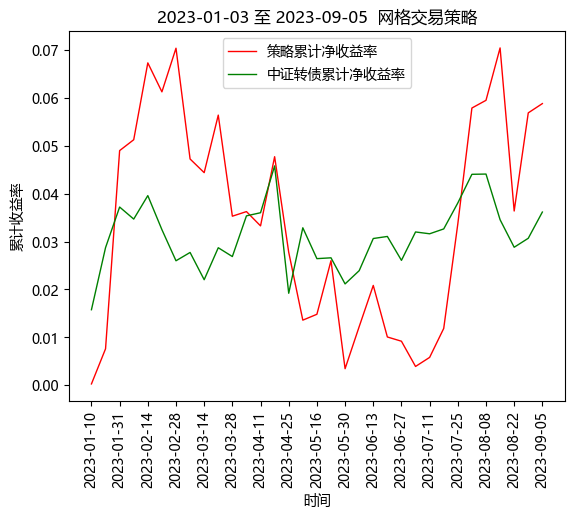

<Figure size 36000x18000 with 0 Axes>

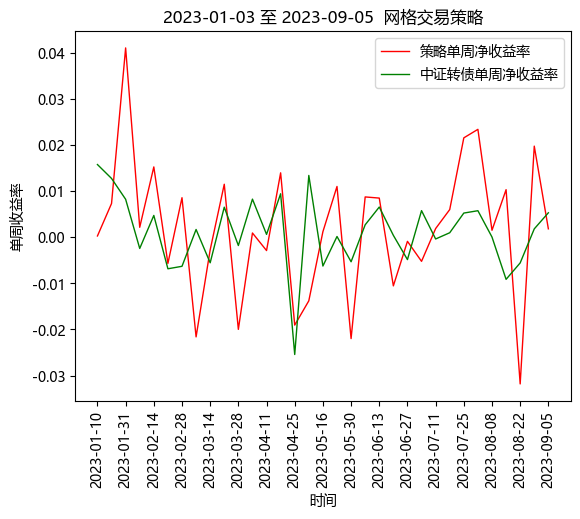

周期： 2023-01-03 至 2023-09-05
策略累计收益率：5.88%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：63.64%
胜率2（收益率高于中证转债指数的比例）：63.64%
夏普比率：0.65
最大回撤：6.25%
年化波动率：10.47%
收益率最好的一周： 2023-01-17 至 2023-01-31
最高单周收益率：4.11%
收益率最差的一周： 2023-08-15 至 2023-08-22
最低单周收益率：-3.18%


周期： 2023-01-03 至 2023-09-05
策略累计收益率：3.05%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：54.55%
胜率2（收益率高于中证转债指数的比例）：57.58%
夏普比率：0.21
最大回撤：9.64%
年化波动率：14.16%
收益率最好的一周： 2023-01-17 至 2023-01-31
最高单周收益率：5.2%
收益率最差的一周： 2023-08-15 至 2023-08-22
最低单周收益率：-4.95%


<Figure size 48000x18000 with 0 Axes>

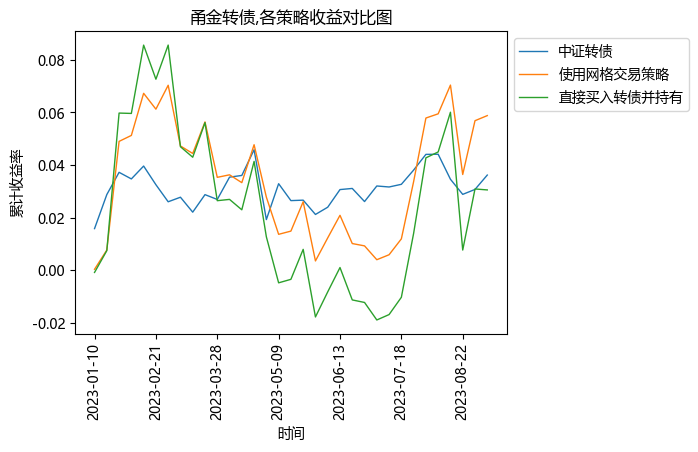

<Figure size 48000x18000 with 0 Axes>

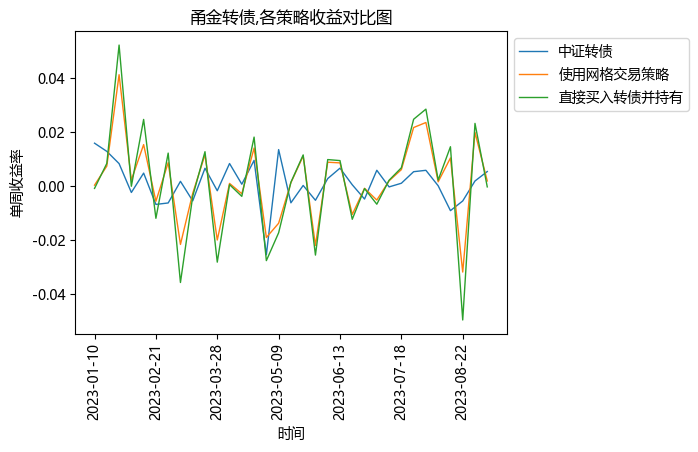


 123120.SZ 隆华转债
8350 154.5 119.72
单周收益率： [0.014361799999999869, 0.008398650264629381, 0.054757294511276644, 0.005667902012034931, 0.0076805543399967036, -0.01625764514172945, -0.009534963886503323, 0.00633514681939662, -0.00906611345284758, 0.02293371305907299, -0.017688206582259114, 0.0026150648486960026, 0.01011808449582996, 0.01409665897496959, -0.030842947041392454, 0.014008743952314662, -0.0010426475674500946, 0.007233911661982395, 0.0050743609669621215, -0.016544055645652422, 2.1800227512080994e-05, 0.014531793254247694, 0.001276528611899197, 0.003930561711658287, -0.004818321662838465, -0.004324411672104067, 0.011045633383013564, -0.010449376629375506, 0.001598071337456597, -0.0038667729850069277, -0.008266462754664361, 0.01650184699103674, -0.0070300531511996445] 
 累积收益率： [0.014361799999999869, 0.022881069999999726, 0.07889126999999951, 0.08500631999999952, 0.09333976999999938, 0.0755646399999994, 0.06530916999999947, 0.07205805999999892, 0.062338659999999324, 0.08670202999999

<Figure size 36000x18000 with 0 Axes>

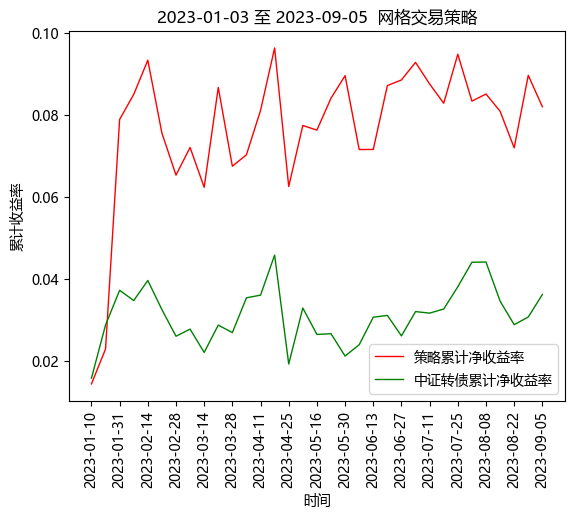

<Figure size 36000x18000 with 0 Axes>

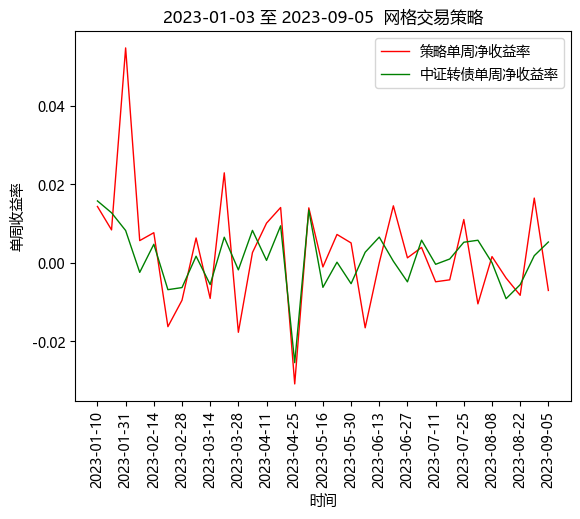

周期： 2023-01-03 至 2023-09-05
策略累计收益率：8.2%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：60.61%
胜率2（收益率高于中证转债指数的比例）：51.52%
夏普比率：0.97
最大回撤：3.08%
年化波动率：10.39%
收益率最好的一周： 2023-01-17 至 2023-01-31
最高单周收益率：5.48%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-3.08%


周期： 2023-01-03 至 2023-09-05
策略累计收益率：5.78%
中证转债累计收益率：3.62%
胜率1（收益率大于0的比例）：60.61%
胜率2（收益率高于中证转债指数的比例）：54.55%
夏普比率：0.46
最大回撤：6.91%
年化波动率：15.9%
收益率最好的一周： 2023-01-17 至 2023-01-31
最高单周收益率：7.53%
收益率最差的一周： 2023-04-18 至 2023-04-25
最低单周收益率：-5.32%


<Figure size 48000x18000 with 0 Axes>

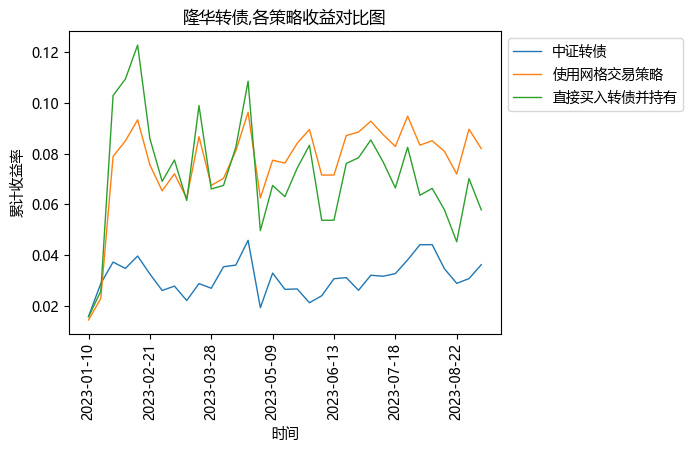

<Figure size 48000x18000 with 0 Axes>

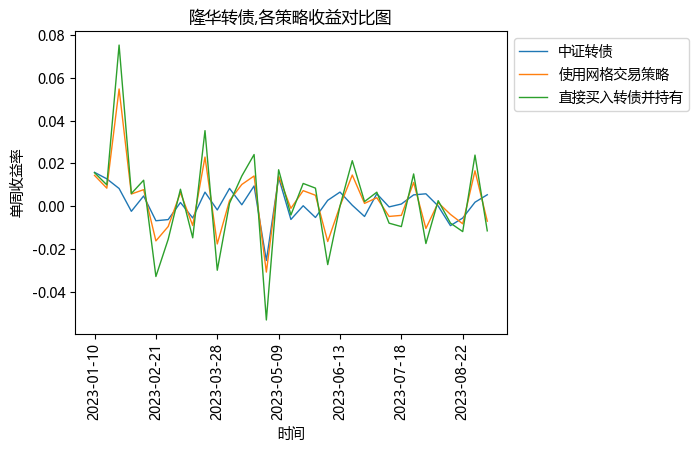

In [80]:
import bisect

start_day = '2023-01-03'
end_day = '2023-09-07'
which_day = 'tue'

# 先实验对某一只转债进行网格化交易

# 选债方法剔除掉目前价格过高的转债（存在下跌的风险），按回测开始日期前半年的正股年化波动率由高到低排序
# 113594.SH  113621.SH  127046.SZ  123088.SZ  113629.SH  127052.SZ  123121.SZ
trade_bond_code_list = ['128117.SZ', '123088.SZ', '123038.SZ', '127028.SZ', '113600.SH', '123145.SZ', '128042.SZ', '113636.SH', '123120.SZ']


for trade_bond_code in trade_bond_code_list:
    trade_bond_name = B_DF.loc[B_DF['bond_code']==trade_bond_code, 'cn'].to_string(index=False)
    print('\n', trade_bond_code, trade_bond_name)
    # 需要交易的转债只数
    trade_bond_code_count = 1

    day_list = sorted(list(A_DF[(A_DF['date'] >= start_day) & (A_DF['date'] <= end_day) & (A_DF['bond_code'] == trade_bond_code)]['date']))
    # print(day_list)


    # 设置初始资金100万元
    initial_money = 1000000

    # 每只转债的最大投入资金限额
    every_bond_max_money = int(initial_money/trade_bond_code_count)

    # 每只转债最大买入份额
    max_limit = int(every_bond_max_money / A_DF[(A_DF['date'] == start_day) & (A_DF['bond_code'] == trade_bond_code)]['lowest_price_n_days'] / 10) * 10

    # 设计 2k + 1 个格子
    n = 11

    # 设置网格的最高点/最低点
    max_price = float(A_DF[(A_DF['date'] == start_day) & (A_DF['bond_code'] == trade_bond_code)]['highest_price_n_days'])
    
    # 为了安全起见最低点设置为100元
    # min_price = 100.00
    min_price = float(A_DF[(A_DF['date'] == start_day) & (A_DF['bond_code'] == trade_bond_code)]['lowest_price_n_days'])

    print(max_limit, max_price, min_price)

    # 设置网格的价格比例
    q = (max_price/min_price) ** (1/(n-1))

    # 字典中存储每个价位应该持有的债券数量
    position_dict = {round(min_price * (q ** i),2) : int(max_limit * (1-i/(n-1)) / 10) * 10 for i in range(n)}

    # 网格价目表
    price_list = [round(min_price * (q ** i),2) for i in range(n)]

    # print(q,price_list,position_dict)


    total_money_list = []

    # dp列表
    A_DF.sort_values(by = ['bond_code','date'], inplace=True, ascending=[True,True])
    dp_list = list(A_DF[(A_DF['date'].isin(day_list)) & (A_DF['bond_code'] == trade_bond_code)]['dp'])

    # print(len(day_list),len(dp_list))

    all_date_positon_details = {}
    for i in range(len(day_list)):  
        index_1 = bisect.bisect_left(price_list, dp_list[i])
        if index_1 > n-1:
            index_1 = n-1
        # print(index_1,dp_list[i])
        all_date_positon_details[day_list[i]] = {trade_bond_code : position_dict[price_list[index_1]]}

    # print(all_date_positon_details)


    # 统计每周账户净值
    test_day_list = list(D_DF[(D_DF['date'] >= start_day) & (D_DF['date'] <= end_day) & (D_DF['which_day'] == which_day)]['date'])

    for i in range(len(day_list)):
        day = day_list[i]
        if i == 0:
            # 第一天换仓时
            total_money_list.append(initial_money)
            current_money = initial_money - get_current_total_money(day, 0, all_date_positon_details[day], A_DF)
        else:
            current_total_money = get_current_total_money(day, current_money, all_date_positon_details[day_list[i-1]], A_DF)
            current_money = current_total_money - get_current_total_money(day, 0, all_date_positon_details[day], A_DF)
            if day in test_day_list:
                total_money_list.append(current_total_money)

    profit = [total_money_list[i] / total_money_list[i-1] - 1 for i in range(1, len(total_money_list))]

    weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = display(profit, test_day_list, C_DF, '网格交易策略', tick_spacing = 2)
    calculate_indicators(test_day_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return)
    
   
    # 直接买（不用网格交易）的收益率
    close_list = list(A_DF[(A_DF['date'].isin(test_day_list)) & (A_DF['bond_code'] == trade_bond_code)]['dp'])
    close_weekly_return = [close_list[i] / close_list[i-1] - 1 for i in range(1, len(close_list))]
    close_cumulative_return = [close_list[i] / close_list[0] - 1 for i in range(1, len(close_list))]
   
    profit_dict = {'使用网格交易策略' : {'weekly_return' : weekly_return, 'cumulative_return' : cumulative_return},
                   '直接买入转债并持有' : {'weekly_return' : close_weekly_return, 'cumulative_return' : close_cumulative_return}}
    trade_dates_list = test_day_list
    
    print('\n')
    calculate_indicators(test_day_list, close_weekly_return, close_cumulative_return, zi_weekly_return, zi_cumulative_return)
    
    display_multiple_strategies(profit_dict, trade_dates_list, zi_weekly_return, zi_cumulative_return, photo_title = trade_bond_name + ',各策略收益对比图', tick_spacing = 5)
    

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- 分页，便于阅读 ---------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

In [8]:
from WindPy import w
import datetime

# 需要获取的日期
need_date = '2022-12-30'
A_DF_one_day = A_DF[A_DF['date']==need_date].copy()

stock_code_list = list(set(A_DF_one_day['sc']))
print(stock_code_list)
w.start()

# 获取年化波动率
volatilityratio = w.wsd(stock_code_list, "volatilityratio", need_date, need_date, "CalculationTime=126;AnnualCoefficient=252").Data[0]
print(volatilityratio)

mapping = dict(zip(stock_code_list, volatilityratio))
print(mapping)

A_DF_one_day['volatilityratio'] = A_DF_one_day['sc'].apply(lambda x : mapping[x])

['002997.SZ', '000411.SZ', '600498.SH', '002749.SZ', '688066.SH', '601016.SH', '300776.SZ', '603799.SH', '600133.SH', '601609.SH', '002822.SZ', '000726.SZ', '002806.SZ', '002446.SZ', '002203.SZ', '603713.SH', '601006.SH', '300296.SZ', '002982.SZ', '603979.SH', '300651.SZ', '300723.SZ', '300078.SZ', '603716.SH', '605189.SH', '688059.SH', '601515.SH', '605222.SH', '300424.SZ', '002614.SZ', '688499.SH', '300511.SZ', '603501.SH', '600061.SH', '600674.SH', '603081.SH', '603055.SH', '300894.SZ', '603278.SH', '688179.SH', '603535.SH', '601330.SH', '300197.SZ', '002851.SZ', '002370.SZ', '000552.SZ', '603320.SH', '002840.SZ', '688030.SH', '300839.SZ', '688096.SH', '002738.SZ', '002714.SZ', '600438.SH', '300283.SZ', '600745.SH', '603568.SH', '300190.SZ', '300253.SZ', '002049.SZ', '002698.SZ', '600075.SH', '002842.SZ', '002067.SZ', '002436.SZ', '688328.SH', '002949.SZ', '300303.SZ', '002850.SZ', '601838.SH', '603708.SH', '601881.SH', '600197.SH', '002548.SZ', '002368.SZ', '300778.SZ', '300871.SZ'

In [9]:
A_DF_one_day

,bond_code,date,cpr,dp,bl,trt,ytm,yl,dl,ia,...,hs,lastday_dp,change,sn,cn,sc,highest_price_n_days,lowest_price_n_days,avg_trt,volatilityratio
9297,110043.SH,2022-12-30,14.3453,110.976,29.213300,2.238200,-3.0906,1.084900,125.3213,1,...,NaN,111.501,-0.004708,无锡银行,无锡转债,600908.SH,124.726,108.656,1.735113,27.251937
10538,110044.SH,2022-12-30,126.5483,194.752,0.707100,41.238000,-32.1140,1.490400,321.3003,1,...,NaN,194.899,-0.000754,广电网络,广电转债,600831.SH,245.610,181.478,63.312829,25.403955
11774,110045.SH,2022-12-30,34.8198,109.425,29.496100,0.586900,-0.0749,1.534200,144.2448,1,...,NaN,109.600,-0.001597,海澜之家,海澜转债,600398.SH,112.997,107.698,0.679241,26.600709
13226,110047.SH,2022-12-30,11.0204,114.721,22.461300,1.245200,0.1294,1.893200,125.7414,1,...,NaN,114.587,0.001169,山鹰国际,山鹰转债,600567.SH,120.002,111.094,1.020020,18.252374
14360,110048.SH,2022-12-30,9.1538,151.158,12.761700,2.361800,-14.9030,1.937000,160.3118,1,...,NaN,150.310,0.005642,福能股份,福能转债,600483.SH,215.880,141.430,4.902404,35.012969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391703,128141.SZ,2022-12-30,7.2753,123.500,12.701500,2.837100,-1.9653,3.964400,130.7753,1,...,NaN,123.860,-0.002907,旺能环境,旺能转债,002034.SZ,166.000,121.800,4.770708,32.876774
392338,128142.SZ,2022-12-30,54.3764,111.000,7.179800,0.892400,0.7538,3.967100,165.3764,1,...,NaN,110.851,0.001344,新乳业,新乳转债,002946.SZ,116.802,109.346,1.368771,31.617169
392965,128143.SZ,2022-12-30,48.7943,117.928,2.440700,2.036600,0.7000,4.024700,166.7223,1,...,NaN,117.898,0.000254,锋龙股份,锋龙转债,002931.SZ,158.402,117.151,56.705567,48.758392
393559,128144.SZ,2022-12-30,35.7857,113.478,9.794100,0.423700,0.0691,4.167100,149.2637,1,...,NaN,113.700,-0.001953,利民股份,利民转债,002734.SZ,127.979,113.478,2.203713,32.860781


In [26]:
# 后面为选择合适标的的过程
print(A_DF_one_day)

print('前n天最高价分位数：')
print('最小值：', A_DF_one_day['highest_price_n_days'].min())
print('25%：', A_DF_one_day['highest_price_n_days'].quantile(0.25))
print('50%：',A_DF_one_day['highest_price_n_days'].quantile(0.5))
print('75%：',A_DF_one_day['highest_price_n_days'].quantile(0.75))
print('最大值：',A_DF_one_day['highest_price_n_days'].max())
print('\n')

print('前n天平均换手率分位数：')
print('最小值：', A_DF_one_day['avg_trt'].min())
print('25%：', A_DF_one_day['avg_trt'].quantile(0.25))
print('50%：',A_DF_one_day['avg_trt'].quantile(0.5))
print('75%：',A_DF_one_day['avg_trt'].quantile(0.75))
print('最大值：',A_DF_one_day['avg_trt'].max())
print('\n')

print('年化波动率分位数：')
print('最小值：', A_DF_one_day['volatilityratio'].min())
print('25%：', A_DF_one_day['volatilityratio'].quantile(0.25))
print('50%：',A_DF_one_day['volatilityratio'].quantile(0.5))
print('75%：',A_DF_one_day['volatilityratio'].quantile(0.75))
print('最大值：',A_DF_one_day['volatilityratio'].max())

        bond_code        date       cpr       dp         bl          trt  \
9297    110043.SH  2022-12-30   14.3453  110.976  29.213300     2.238200   
10538   110044.SH  2022-12-30  126.5483  194.752   0.707100    41.238000   
11774   110045.SH  2022-12-30   34.8198  109.425  29.496100     0.586900   
13226   110047.SH  2022-12-30   11.0204  114.721  22.461300     1.245200   
14360   110048.SH  2022-12-30    9.1538  151.158  12.761700     2.361800   
...           ...         ...       ...      ...        ...          ...   
391703  128141.SZ  2022-12-30    7.2753  123.500  12.701500     2.837100   
392338  128142.SZ  2022-12-30   54.3764  111.000   7.179800     0.892400   
392965  128143.SZ  2022-12-30   48.7943  117.928   2.440700     2.036600   
393559  128144.SZ  2022-12-30   35.7857  113.478   9.794100     0.423700   
394137  128145.SZ  2022-12-30   -0.5971  136.000   3.400119  1143.055611   

            ytm        yl        dl  ia  ...  hs  lastday_dp    change    sn  \
9297   

In [20]:
# 条件1：设置网格上限不超过158元，即半年内最高价不超过158元
# 条件2：交易足够活跃，因此需要换手率较高，设置当日换手率>=2%
# 条件3：年化波动率>=50%

output_df = A_DF_one_day[(A_DF_one_day['highest_price_n_days']<=160) & 
                         (A_DF_one_day['highest_price_n_days'] - A_DF_one_day['lowest_price_n_days']>=30) &
                         (A_DF_one_day['dp']<=130) & 
                         (A_DF_one_day['avg_trt']>=5) & 
                         (A_DF_one_day['volatilityratio']>=50) & 
                         (~A_DF_one_day['sn'].str.contains('ST'))].copy()
output_df.sort_values(by='volatilityratio',ascending=False, inplace=True)
print(output_df[['bond_code','cn','sc','sn','dp','dl','bl','trt','ytm','yl']])
print(list(output_df['bond_code']))

        bond_code    cn         sc    sn       dp        dl         bl  \
375615  128117.SZ  道恩转债  002838.SZ  道恩股份  115.000  197.3218   3.585500   
221765  123088.SZ  威唐转债  300707.SZ  威唐工业  117.112  173.9693   3.011300   
194572  123038.SZ  联得转债  300545.SZ  联得装备  125.800  217.0034   1.472600   
240007  123125.SZ  元力转债  300174.SZ  元力股份  113.219  112.5409   1.412758   
275818  127028.SZ  英特转债  000411.SZ  英特集团  120.600  133.4866   5.760300   
134901  113600.SH  新星转债  603978.SH  深圳新星  114.477  161.8206   4.530300   
246892  123145.SZ  药石转债  300725.SZ  药石科技  123.816  166.6735  11.494300   
329134  128042.SZ  凯中转债  002823.SZ  凯中精密  116.758  145.3832   4.154300   
151329  113636.SH  甬金转债  603995.SH  甬金股份  115.811  165.8286   9.995400   
237772  123120.SZ  隆华转债  300263.SZ  隆华科技  119.720  150.7695   7.982600   

              trt     ytm        yl  
375615  28.890900  1.8534  3.504100  
221765   1.377800  0.7159  3.958900  
194572   5.405400 -2.4909  2.986300  
240007  67.563305 -0.7801  0.0273